## 长短期记忆网络（LSTM）
⻓期以来，隐变量模型存在着⻓期信息保存和短期输⼊缺失的问题。解决这⼀问题的最早⽅法之⼀是⻓短期
存储器（long short-term memory，LSTM）(Hochreiter and Schmidhuber, 1997)。它有许多与⻔控循环单
元（9.1节）⼀样的属性。有趣的是，⻓短期记忆⽹络的设计⽐⻔控循环单元稍微复杂⼀些，却⽐⻔控循环单
元早诞⽣了近20年。

## 门控记忆元
可以说，⻓短期记忆⽹络的设计灵感来⾃于计算机的逻辑⻔。⻓短期记忆⽹络引⼊了记忆元（memory cell），
或简称为单元（cell）。有些⽂献认为记忆元是隐状态的⼀种特殊类型，它们与隐状态具有相同的形状，其设
计⽬的是⽤于记录附加的信息。为了控制记忆元，我们需要许多⻔。其中⼀个⻔⽤来从单元中输出条⽬，我
们将其称为输出⻔（output gate）。另外⼀个⻔⽤来决定何时将数据读⼊单元，我们将其称为输⼊⻔（input
gate）。我们还需要⼀种机制来重置单元的内容，由遗忘⻔（forget gate）来管理，这种设计的动机与⻔控循
环单元相同，能够通过专⽤机制决定什么时候记忆或忽略隐状态中的输⼊。让我们看看这在实践中是如何运
作的。


### 输入门和输出门
就如在⻔控循环单元中⼀样，当前时间步的输⼊和前⼀个时间步的隐状态作为数据送⼊⻓短期记忆⽹络的⻔
中，如 图9.2.1所⽰。它们由三个具有sigmoid激活函数的全连接层处理，以计算输⼊⻔、遗忘⻔和输出⻔的
值。因此，这三个⻔的值都在(0, 1)的范围内。  
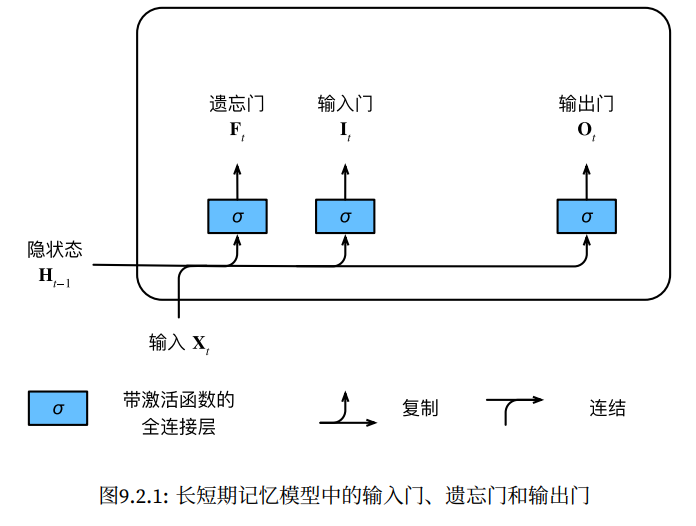  

我们来细化⼀下⻓短期记忆⽹络的数学表达。假设有h个隐藏单元，批量⼤⼩为n，输⼊数为d。因此，输⼊
为Xt ∈ Rn×d，前⼀时间步的隐状态为Ht−1 ∈ Rn×h。相应地，时间步t的⻔被定义如下：输⼊⻔是It ∈ R
n×h，遗忘⻔是Ft ∈ Rn×h，输出⻔是Ot ∈ Rn×h。它们的计算⽅法如下：  
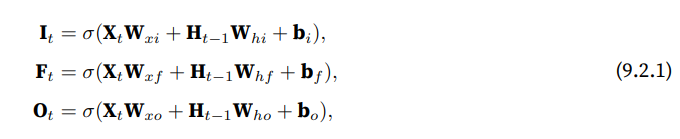  

其中Wxi, Wxf , Wxo ∈ Rd×h 和Whi, Whf , Who ∈ Rh×h是权重参数，bi
, bf , bo ∈ R1×h是偏置参数。

### 候选记忆元
由于还没有指定各种⻔的操作，所以先介绍候选记忆元（candidate memory cell）C˜
t ∈ Rn×h。它的计算与上⾯描述的三个⻔的计算类似，但是使⽤tanh函数作为激活函数，函数的值范围为(−1, 1)。下⾯导出在时间
步t处的⽅程：  
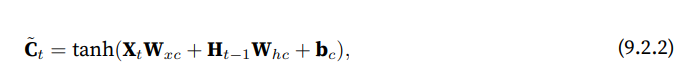  

其中Wxc ∈ Rd×h和 Whc ∈ Rh×h是权重参数，bc ∈ R1×h是偏置参数。  

候选记忆元的如 图9.2.2所⽰。  

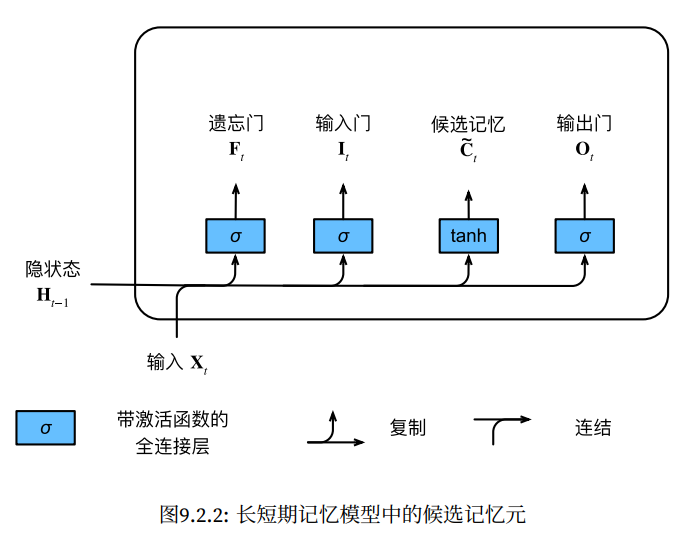


### 记忆元
在⻔控循环单元中，有⼀种机制来控制输⼊和遗忘（或跳过）。类似地，在⻓短期记忆⽹络中，也有两个⻔⽤于
这样的⽬的：输⼊⻔It控制采⽤多少来⾃C˜t的新数据，⽽遗忘⻔Ft控制保留多少过去的记忆元Ct−1 ∈ R
n×h的内容。使⽤按元素乘法，得出：

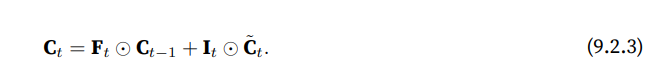  

如果遗忘⻔始终为1且输⼊⻔始终为0，则过去的记忆元Ct−1 将随时间被保存并传递到当前时间步。引⼊这种
设计是为了缓解梯度消失问题，并更好地捕获序列中的⻓距离依赖关系。

这样我们就得到了计算记忆元的流程图，如 图9.2.3。  

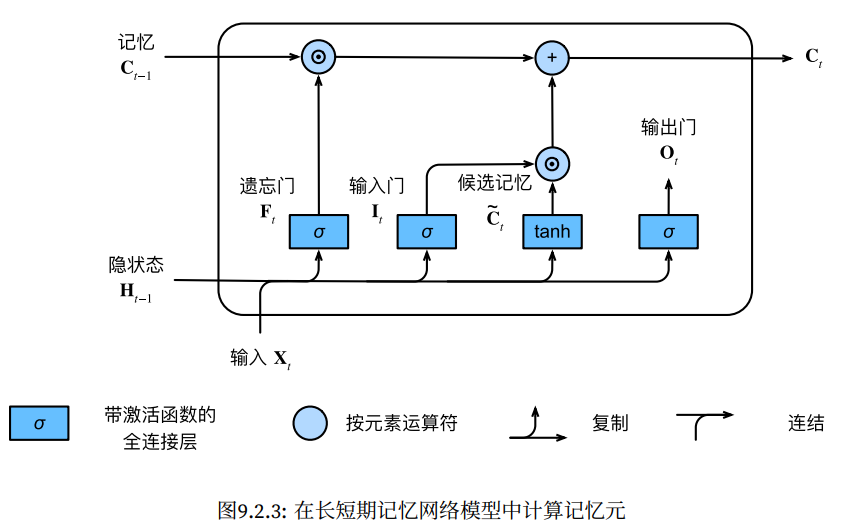  



### 隐状态
最后，我们需要定义如何计算隐状态 Ht ∈ R
n×h，这就是输出⻔发挥作⽤的地⽅。在⻓短期记忆⽹络中，它
仅仅是记忆元的tanh的⻔控版本。这就确保了Ht的值始终在区间(−1, 1)内：  
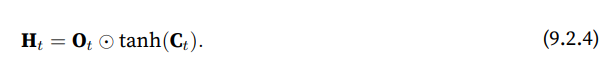  

只要输出⻔接近1，我们就能够有效地将所有记忆信息传递给预测部分，⽽对于输出⻔接近0，我们只保留记
忆元内的所有信息，⽽不需要更新隐状态。  
图9.2.4提供了数据流的图形化演⽰。

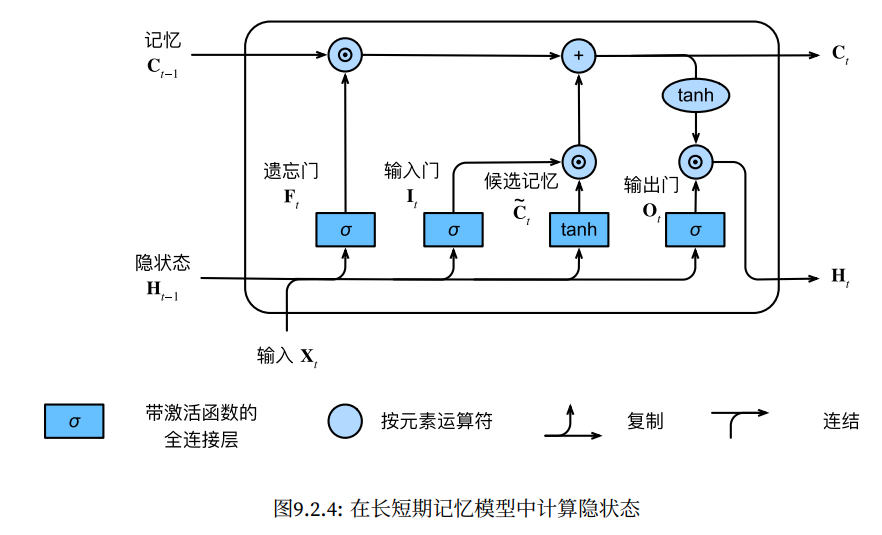  


## 从零开始实现
从零开始实现⻓短期记忆⽹络。与 8.5节中的实验相同，我们⾸先加载时光机器数据集。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 初始化模型参数
接下来，我们需要定义和初始化模型参数。如前所述，超参数num_hiddens定义隐藏单元的数量。我们按照标
准差0.01的⾼斯分布初始化权重，并将偏置项设为0。


In [2]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)),
        normal((num_hiddens, num_hiddens)),
        torch.zeros(num_hiddens, device=device))
    
    W_xi, W_hi, b_i = three() # 输⼊⻔参数
    W_xf, W_hf, b_f = three() # 遗忘⻔参数
    W_xo, W_ho, b_o = three() # 输出⻔参数
    W_xc, W_hc, b_c = three() # 候选记忆元参数

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
             b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params




### 定义模型
在初始化函数中，⻓短期记忆⽹络的隐状态需要返回⼀个额外的记忆元，单元的值为0，形状为（批量⼤⼩，
隐藏单元数）。因此，我们得到以下的状态初始化。

In [3]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

实际模型的定义与我们前⾯讨论的⼀样：提供三个⻔和⼀个额外的记忆元。请注意，只有隐状态才会传递到
输出层，⽽记忆元Ct不直接参与输出计算。


In [4]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
    W_hq, b_q] = params
    (H, C) = state
    outputs = []
    
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

### 训练和预测
让我们通过实例化 8.5节中引⼊的RNNModelScratch类来训练⼀个⻓短期记忆⽹络，就如我们在 9.1节中所做
的⼀样。

perplexity 1.1, 36729.0 tokens/sec on cuda:0
time travellerif that not said the time travellerit would be rem
traveller we can is been at wirk thepresher s amainst snive


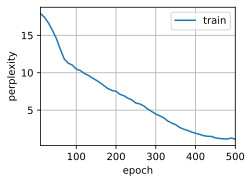

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1

model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
                            
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)


## 简洁实现
使⽤⾼级API，我们可以直接实例化LSTM模型。⾼级API封装了前⽂介绍的所有配置细节。这段代码的运⾏速
度要快得多，因为它使⽤的是编译好的运算符⽽不是Python来处理之前阐述的许多细节。


perplexity 1.0, 135634.6 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


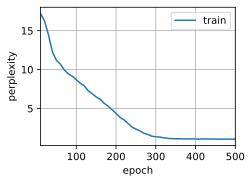

In [6]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device) #这里的意思是将模型和参数转移到显卡上进行运算
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

⻓短期记忆⽹络是典型的具有重要状态控制的隐变量⾃回归模型。多年来已经提出了其许多变体，例如，多
层、残差连接、不同类型的正则化。然⽽，由于序列的⻓距离依赖性，训练⻓短期记忆⽹络和其他序列模型
（例如⻔控循环单元）的成本是相当⾼的。在后⾯的内容中，我们将讲述更⾼级的替代模型，如Transformer。


## 小结
* ⻓短期记忆⽹络有三种类型的⻔：输⼊⻔、遗忘⻔和输出⻔。
* ⻓短期记忆⽹络的隐藏层输出包括“隐状态”和“记忆元”。只有隐状态会传递到输出层，⽽记忆元完全属于内部信息。
* ⻓短期记忆⽹络可以缓解梯度消失和梯度爆炸。